Based on Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow book, taken from https://github.com/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb


In [ ]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


# Basic RNNs

### Generate the Dataset

In [ ]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [ ]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [ ]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

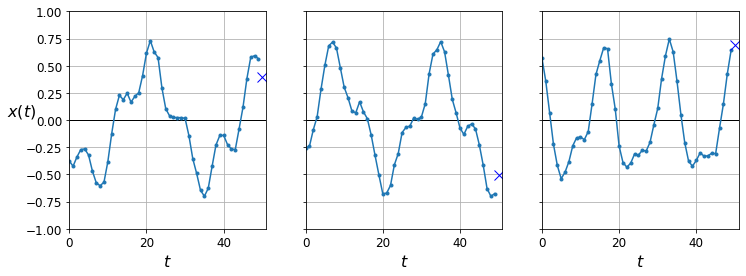

In [ ]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
plt.show()

### Computing Some Baselines

Naive predictions (just predict the last observed value):

In [ ]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

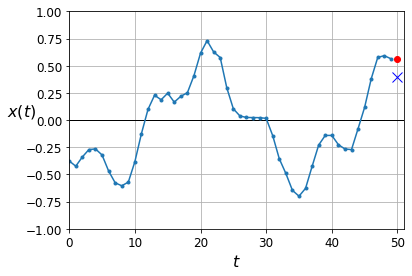

In [ ]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Linear predictions:

In [ ]:
X_train_trim = X_train[:,:,0]
X_train_trim.shape
y_train_trim = y_train[:,0]
X_valid_trim = X_valid[:,:,0]
y_valid_trim = y_valid[:,0]

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(1,input_shape=[50])
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train_trim, y_train_trim, epochs=10,
                    validation_data=(X_valid_trim, y_valid_trim))

Epoch 1/10
219/219 [==============================] - 6s 8ms/step - loss: 0.1001 - val_loss: 0.0545
Epoch 2/10
219/219 [==============================] - 1s 6ms/step - loss: 0.0379 - val_loss: 0.0266
Epoch 3/10
219/219 [==============================] - 1s 6ms/step - loss: 0.0202 - val_loss: 0.0157
Epoch 4/10
219/219 [==============================] - 1s 5ms/step - loss: 0.0131 - val_loss: 0.0116
Epoch 5/10
219/219 [==============================] - 1s 5ms/step - loss: 0.0103 - val_loss: 0.0098
Epoch 6/10
219/219 [==============================] - 1s 6ms/step - loss: 0.0089 - val_loss: 0.0087
Epoch 7/10
219/219 [==============================] - 1s 3ms/step - loss: 0.0080 - val_loss: 0.0079
Epoch 8/10
219/219 [==============================] - 1s 3ms/step - loss: 0.0073 - val_loss: 0.0071
Epoch 9/10
219/219 [==============================] - 1s 3ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 10/10
219/219 [==============================] - 1s 3ms/step - loss: 0.0061 - val_loss: 0.0062

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.evaluate(X_valid, y_valid)

InvalidArgumentError: ignored

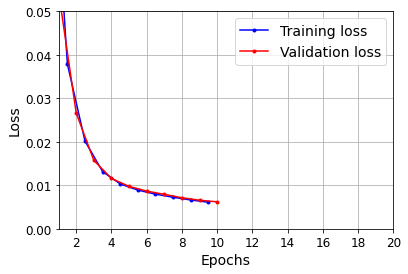

In [ ]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 [==============================] - 0s 1ms/step


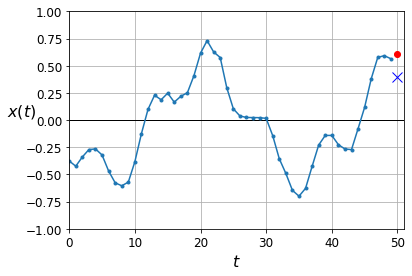

In [ ]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Using a Simple RNN

In [ ]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


219/219 [==============================] - 8s 33ms/step - loss: 0.0313 - val_loss: 0.0127
Epoch 2/10
219/219 [==============================] - 11s 51ms/step - loss: 0.0119 - val_loss: 0.0112
Epoch 3/10
219/219 [==============================] - 7s 31ms/step - loss: 0.0115 - val_loss: 0.0110
Epoch 4/10
219/219 [==============================] - 7s 31ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 5/10
219/219 [==============================] - 8s 36ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 6/10
219/219 [==============================] - 8s 36ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 7/10
219/219 [==============================] - 7s 32ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 8/10
219/219 [==============================] - 7s 34ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 9/10
219/219 [==============================] - 7s 31ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 10/10
219/219 [==============================] - 7s 31ms/step - loss: 0.0114 - val_loss: 0.0110

In [ ]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 6ms/step - loss: 0.0110


0.01095960196107626

Colab

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


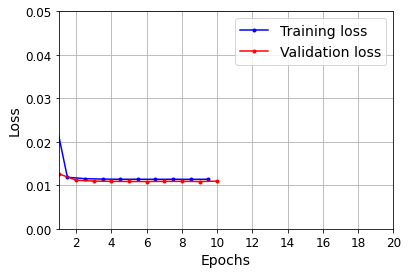

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 [==============================] - 0s 5ms/step


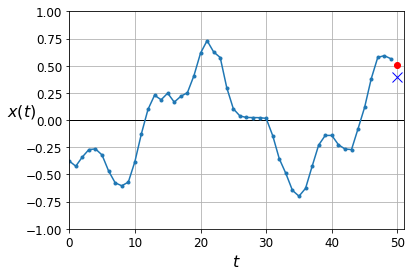

In [ ]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [ ]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(2, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=2,
                    validation_data=(X_valid, y_valid))

Epoch 1/2
219/219 [==============================] - 10s 43ms/step - loss: 0.2068 - val_loss: 0.1163
Epoch 2/2
219/219 [==============================] - 7s 32ms/step - loss: 0.0687 - val_loss: 0.0352


Colab

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 2)                 8         
                                                                 
Total params: 8
Trainable params: 8
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print(model.layers[0].trainable_weights)

[<tf.Variable 'simple_rnn_2/simple_rnn_cell_2/kernel:0' shape=(1, 2) dtype=float32, numpy=array([[1.5226068 , 0.29112485]], dtype=float32)>, <tf.Variable 'simple_rnn_2/simple_rnn_cell_2/recurrent_kernel:0' shape=(2, 2) dtype=float32, numpy=
array([[-0.4525653 ,  0.505745  ],
       [ 0.20200005, -0.7155216 ]], dtype=float32)>, <tf.Variable 'simple_rnn_2/simple_rnn_cell_2/bias:0' shape=(2,) dtype=float32, numpy=array([-0.01748272,  0.0246423 ], dtype=float32)>]


## Deep RNNs

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

In [ ]:
model.summary()

In [ ]:
model.evaluate(X_valid, y_valid)

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [ ]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Forecasting Several Steps Ahead

In [ ]:
np.random.seed(43) # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

In [ ]:
Y_pred.shape

In [ ]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

Now let's use this model to predict the next 10 values. We first need to regenerate the sequences with 9 more time steps.

In [ ]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

Now let's predict the next 10 values one by one:

In [ ]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

In [ ]:
Y_pred.shape

In [ ]:
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

Let's compare this performance with some baselines: naive predictions and a simple linear model:

In [ ]:
Y_naive_pred = Y_valid[:, -1:]
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=10,
                    validation_data=(X_valid, Y_valid))

Now let's create an RNN that predicts all 10 next values at once:

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=10,
                    validation_data=(X_valid, Y_valid))

In [ ]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

In [ ]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

Now let's create an RNN that predicts the next 10 steps at each time step. That is, instead of just forecasting time steps 50 to 59 based on time steps 0 to 49, it will forecast time steps 1 to 10 at time step 0, then time steps 2 to 11 at time step 1, and so on, and finally it will forecast time steps 50 to 59 at the last time step. Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.

In [ ]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [ ]:
X_train.shape, Y_train.shape

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=10,
                    validation_data=(X_valid, Y_valid))

About "TimeDistributed": it applies the output Dense layer at every time step.

In [ ]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

In [ ]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# LSTMs

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=10,
                    validation_data=(X_valid, Y_valid))

In [ ]:
model.summary()

In [ ]:
model.evaluate(X_valid, Y_valid)

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [ ]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

In [ ]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# GRUs

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=10,
                    validation_data=(X_valid, Y_valid))

In [ ]:
model.summary()

In [ ]:
model.evaluate(X_valid, Y_valid)

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [ ]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

In [ ]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()